In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns
import os
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, KFold

### UTILS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score, roc_curve
!pip install torch==1.4.0
import torch

!pip install -U flair
import flair
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, Sentence, BertEmbeddings, RoBERTaEmbeddings, XLNetEmbeddings


Requirement already up-to-date: flair in /usr/local/lib/python3.6/dist-packages (0.4.5)


In [ ]:
RANDOM_SEED = 78973
np.random.seed(RANDOM_SEED)

path = "drive/My Drive/Studia/Wybrane Zaawansowane Zagadnienia Uczenia Maszynowego"
train_path = os.path.join(path, "data/train.tsv")


##########  UTILS ##########

def get_label(data):
    label = np.zeros_like(data["label"], dtype=np.int32)
    label[data["label"] == "pants-fire"] = 1
    return label


def get_multi_label(data):
    label_dict = {
        "true": 5,
        "mostly-true": 4,
        "half-true": 3,
        "barely-true": 2,
        "false": 1,
        "pants-fire": 0
    }
    label = [label_dict[word_label] for word_label in data["label"].values]
    return np.array(label)


def plot_roc(y, probs, verbose=True):
    if len(probs.shape) > 1:
        preds = probs[:,1]
    else:
        preds = probs
    fpr, tpr, threshold = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)

    if verbose:
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    return roc_auc
    
    
def evaluate(model, x, y, verbose=True):
    probs = model.predict_proba(x)
    y_pred = probs[:, 1] > 0.5
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    if verbose:
        print("Accuracy: {:.2f}".format(acc * 100))
        print("F-1 score: {:.4f}".format(f1))
    return plot_roc(y, probs, verbose=verbose)
    
    
def instantiate(foo):
    return foo()
    

@instantiate
def Imputer():
    def impute(x_array):
        if type(x_array) == pd.core.series.Series:
            x_array = x_array.values
        return np.array(["unknown" if x is np.nan else x for x in x_array])
    return FunctionTransformer(impute)


@instantiate
def Vectorizer():
    return TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.95, max_features=10_000)


@instantiate
def Splitter():
    def split_subject(x_array):
        if type(x_array) == pd.core.series.Series:
            x_array = x_array.values
        return np.array([x.replace(",", " ") for x in x_array])
    return FunctionTransformer(split_subject)


@instantiate
def Embedder():
    def embed(x_array):
        if type(x_array) == pd.core.series.Series:
            x_array = x_array.values
        
        roberta = RoBERTaEmbeddings("roberta-base")
        document_embeddings = DocumentPoolEmbeddings([roberta], pooling="mean", fine_tune_mode="none")
        embedding_list = []
        for text in tqdm(x_array):
            sentence = Sentence(text)
            document_embeddings.embed(sentence)
            embedding = sentence.get_embedding()
            embedding_list.append(embedding)
        embedding_list = torch.stack(embedding_list)
        return embedding_list.cpu().detach().numpy()
    return FunctionTransformer(embed)

In [79]:
data = pd.read_csv(train_path, sep="\t")

#
!pip install -U spacy
import spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg
# load model
nlp = spacy.load("en_core_web_lg")
print("Applyting transformation to dataset")
data["statement_spacy"] = data.statement.apply(nlp)

def label_from_multi(y_multi):
    return np.array([1 if y == 0 else 0 for y in y_multi])

x_all = data.drop("label", axis=1)
y_all_multi = get_multi_label(data)
y_all = label_from_multi(y_all_multi)

print("1s in a dataset: {:.2f}%".format(y_train.mean()*100))
x_all.head()

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
Applyting transformation to dataset
1s in a dataset: 8.19%


,statement,subject,speaker,speaker_job,state,party,context,statement_spacy
0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,"(When, did, the, decline, of, coal, start, ?, ..."
1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver,"(Hillary, Clinton, agrees, with, John, McCain,..."
2,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release,"(Health, care, reform, legislation, is, likely..."
3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,"(The, economic, turnaround, started, at, the, ..."
4,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,a an online opinion-piece,"(The, Chicago, Bears, have, had, more, startin..."


In [ ]:
weight_dict = {
            0: 1,
            1: 0.4,
            2: 1,
            3: 1.6,
            4: 2.2,
            5: 2.8
        }
weights = np.array([weight_dict[y] for y in y_train_multi])

In [81]:
impute_embed = Pipeline([
    ("imputer", Imputer), ("embedder", Embedder)
])

embedder_column_transformer = ColumnTransformer([
        ("statement_embedder", Embedder , "statement"),
        ("context", impute_embed, "context")
    ])

x_embed = embedder_column_transformer.fit_transform(x_all)

In [82]:
x_embed.shape

(10268, 1536)

In [ ]:
impute_vectorize = Pipeline([
    ("imputer", Imputer),("vectorizer", Vectorizer)])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.85, max_features=100))
])

speaker_vectorize = Pipeline([
    ("imputer", Imputer),("vectorizer", TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.85, max_features=100))])

job_vectorize = Pipeline([
    ("imputer", Imputer),("vectorizer", TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.85, max_features=10_000))])

state_vectorize = Pipeline([
    ("imputer", Imputer),("vectorizer", TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.85, max_features=10_000))])

party_vectorize = Pipeline([
    ("imputer", Imputer),("vectorizer", TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.85, max_features=10_000))])

def lemmatize(x):
  l = []
  for d in x:
    l.append(" ".join(t.lemma_ for t in d))
  return l
Lemmatizer = FunctionTransformer(lemmatize)
statement_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.85, max_features=10_000)
statement_vectorize = Pipeline([
    ("lemmarizer", Lemmatizer), ("statement_spacy_vectorizer", statement_vectorizer)
])

context_vectorize = Pipeline([
    ("imputer", Imputer), ("context_vectorizer", TfidfVectorizer(stop_words="english", min_df=0.0005, max_df=0.85, max_features=10_000))
])

column_transformer = ColumnTransformer([
        ("vectorizer", statement_vectorize, "statement_spacy"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("speaker", speaker_vectorize, "speaker"),
        ("job", job_vectorize, "speaker_job"),
        ("state", state_vectorize, "state"),
        ("party", party_vectorize, "party"),
        # ("context", context_vectorize, "context")
    ])

predictor = LogisticRegression(max_iter=10000, C=0.1, tol=1e-6)

In [84]:
kf = KFold(n_splits=10)
kf.get_n_splits(x_all)

def transform(x, index, train=True):
    x_t = column_transformer.fit_transform(x) if train else column_transformer.transform(x)
    x_final = np.concatenate([x_t.toarray(), x_embed[index]], axis=1)
    return x_final

aucs = []
for train_index, test_index in tqdm(kf.split(x_all)):
    x_train, x_test = x_all.iloc[train_index], x_all.iloc[test_index]
    y_train_multi, y_test_multi = y_all_multi[train_index], y_all_multi[test_index]
    y_train = label_from_multi(y_train_multi)
    y_test = label_from_multi(y_test_multi)

    x_train_final = transform(x_train, train_index)
    x_test_final = transform(x_test, test_index, train=False)
    
    sample_weight = np.array([weight_dict[y] for y in y_train_multi])

    predictor.fit(x_train_final, y_train, sample_weight=sample_weight)
    aucs.append(evaluate(predictor, x_test_final, y_test, verbose=False))

In [85]:
aucs = np.array(aucs)
print(aucs.mean(), aucs.std())

0.7859554564368674 0.021431835094341607


In [86]:
print(aucs)

[0.76523422 0.77962918 0.81807169 0.79777695 0.76812909 0.79159723
 0.76469367 0.76396018 0.78373613 0.82672621]


In [87]:
aucs_standard = np.array([0.75204514, 0.78076554, 0.81795688, 0.80492855, 0.76139979,
       0.77341817, 0.7719995 , 0.77525915, 0.7594404 , 0.81624709])
print(aucs_standard.mean(), aucs_standard.std())

0.781346021 0.022446426243429674


In [88]:
for s1, s2 in zip(aucs, aucs_standard):
  print("{:.2f} vs {:.2f}".format(s1*100, s2*100))

76.52 vs 75.20
77.96 vs 78.08
81.81 vs 81.80
79.78 vs 80.49
76.81 vs 76.14
79.16 vs 77.34
76.47 vs 77.20
76.40 vs 77.53
78.37 vs 75.94
82.67 vs 81.62


--- 
## Training full model

In [89]:
x_all.shape

(10268, 8)

In [90]:
x_all_t = column_transformer.fit_transform(x_all)
x_final_evaluation_train = np.concatenate([x_all_t.toarray(), x_embed], axis=1)
sample_weight = np.array([weight_dict[y] for y in y_all_multi])
predictor.fit(x_final_evaluation_train, y_all, sample_weight=sample_weight)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)

Accuracy: 92.55
F-1 score: 0.2265


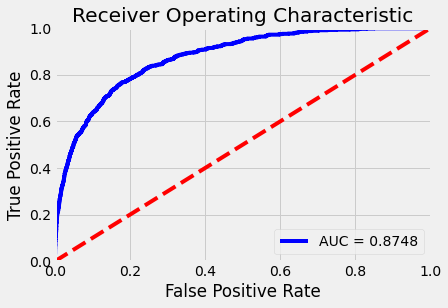

0.87476986633726

In [91]:
# evaluation on training data to make sure the model is fitted
evaluate(predictor, x_final_evaluation_train, y_all)

---
## Saving predictions

In [92]:
test_path = os.path.join(path, "data/test_noy.tsv")

final_evaluation = pd.read_csv(test_path, sep="\t")
final_evaluation.head()

,label,statement,subject,speaker,speaker_job,state,party,context
0,--,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,a news conference
1,--,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,comments on ABC's This Week.
2,--,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,a radio show
3,--,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,a web video
4,--,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,a campaign website


In [ ]:
# Spacy shit
final_evaluation["statement_spacy"] = final_evaluation.statement.apply(nlp)

In [ ]:
# Applying just transform of column transformer (without fitting again)
x_final_evaluation_test = final_evaluation.drop("label", axis=1)
x_final_evaluation_t = column_transformer.transform(x_final_evaluation_test)

In [95]:
# Extracting embeddings from embedder_column_transformer (fitting doesn't change anything here)
x_final_evaluation_embed = embedder_column_transformer.fit_transform(x_final_evaluation_test)

In [ ]:
x_final_evaluation_final = np.concatenate([x_final_evaluation_t.toarray(), x_final_evaluation_embed], axis=1)
probas = predictor.predict_proba(x_final_evaluation_final)

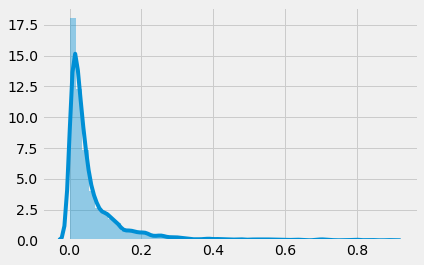

In [97]:
sns.distplot(probas[:, 1])

In [99]:
print(np.mean(probas[:, 1] > 0.5), np.sum((probas[:, 1] > 0.5)))
final_scores = probas[:, 1]
final_scores

0.01364522417153996 35


array([0.01633087, 0.05361751, 0.13232583, ..., 0.09331416, 0.26961769,
       0.0423361 ])

In [100]:
result_list = ["Przemysław Kaleta\n"] + ["{}\n".format(str(score)) for score in final_scores]
result_list[:10]

['Przemysław Kaleta\n',
 '0.016330869304256288\n',
 '0.053617506756676536\n',
 '0.13232583432520648\n',
 '0.1109290007916135\n',
 '0.024526327119666843\n',
 '0.06562331622566187\n',
 '0.13417880540136026\n',
 '0.02562913553549261\n',
 '0.019333114116266162\n']

In [ ]:
save_path = os.path.join(path, "data/kaletap_fact_checking_scores.res")
with open(save_path, "w") as f:
  f.writelines(result_list)

In [102]:
# Checking the correctness of saving
submission = pd.read_csv(save_path, sep="\t")
submission

,Przemysław Kaleta
0,0.016331
1,0.053618
2,0.132326
3,0.110929
4,0.024526
...,...
2560,0.001406
2561,0.014059
2562,0.093314
2563,0.269618
